In [2]:
# Standard library imports
import os
import random

# Third-party imports
import numpy as np
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from IPython.display import HTML, display
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

# Local imports
from safetytooling.internals.model_wrapper import LanguageModelWrapper, ModelConfig
from safetytooling.internals.utils import *
from safetytooling.internals.visuals import prompt_centric_view_generic

### Load the model and harmful dataset

In [3]:
wrapped_model = LanguageModelWrapper(
    model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    config=ModelConfig(
        torch_dtype=torch.float16,
        attn_implementation="sdpa",
    )
)

jailbreak_dataset = load_dataset("Mechanistic-Anomaly-Detection/llama3-jailbreaks")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
short_benign_prompts = [x for x in jailbreak_dataset["benign_instructions_train"]["prompt"] if len(x) < 200]
short_harmful_prompts = [x for x in jailbreak_dataset["harmful_instructions_train"]["prompt"] if len(x) < 200][:len(short_benign_prompts)]

# Make sure order is random
random.shuffle(short_benign_prompts)
random.shuffle(short_harmful_prompts)

# Split benign prompts and their residual activations
split_point = int(0.8 * len(short_benign_prompts))
benign_prompts_train = short_benign_prompts[:split_point]
benign_prompts_test = short_benign_prompts[split_point:]
harmful_prompts_train = short_harmful_prompts[:split_point]
harmful_prompts_test = short_harmful_prompts[split_point:]

### Compute the refusal direction using mean-diff

In [5]:
# Get residual activations for train and test sets

with torch.no_grad():
    benign_res_acts_train = wrapped_model.get_residual_acts(benign_prompts_train, batch_size=32)
    benign_res_acts_test = wrapped_model.get_residual_acts(benign_prompts_test, batch_size=32)
    harmful_res_acts_train = wrapped_model.get_residual_acts(harmful_prompts_train, batch_size=32)
    harmful_res_acts_test = wrapped_model.get_residual_acts(harmful_prompts_test, batch_size=32)


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
def get_auroc(input_acts, labels, vector):
    # Ensure all tensors are on the same device
    device = vector.device
    input_acts = input_acts.to(device)
    labels = labels.to(device)
    # Convert BFloat16 to Float32 for computation
    input_acts = input_acts.to(torch.float32)
    vector = vector.to(torch.float32)
    # Calculate scores as dot product of input_acts with vector
    scores = torch.matmul(input_acts, vector)
    # Convert to numpy arrays for sklearn
    scores_np = scores.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy()
    # Calculate and return AUROC
    auroc = roc_auc_score(labels_np, scores_np)
    return auroc

layer_idx = 12

# For training data
train_input_acts, train_labels = get_labeled(
    benign_res_acts_train[layer_idx], 
    harmful_res_acts_train[layer_idx], 
    aggregation="last"
)
vector = get_steering_vector(train_input_acts, train_labels, method="mean_diff", normalized=False).cuda()

# For test data
test_input_acts, test_labels = get_labeled(
    benign_res_acts_test[layer_idx], 
    harmful_res_acts_test[layer_idx], 
    aggregation="last"
)

# Calculate AUROC on test data
auroc = get_auroc(test_input_acts, test_labels, vector)
print(f"AUROC for layer {layer_idx}: {auroc}")


AUROC for layer 12: 1.0


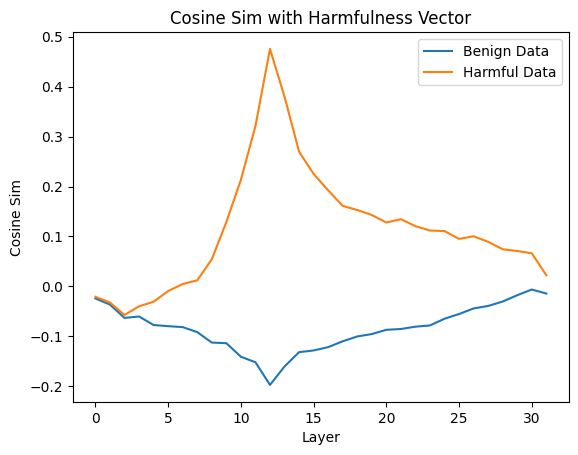

In [7]:
benign_refusal_cos_sim = []
harmful_refusal_cos_sim = []

for layer in range(len(benign_res_acts_test)):
    benign_layer_acts = benign_res_acts_test[layer].to(torch.float32)
    harmful_layer_acts = harmful_res_acts_test[layer].to(torch.float32)

    reshape_vector = vector.to(torch.float32).detach().cpu()[None, :].repeat(len(benign_layer_acts), 1) 
    # Calculate cosine similarity for benign activations
    benign_cos_sim = cosine_similarity(benign_layer_acts[:, -1, :], reshape_vector)
    benign_refusal_cos_sim.append(benign_cos_sim[0][0])
    
    # Calculate cosine similarity for harmful activations
    harmful_cos_sim = cosine_similarity(harmful_layer_acts[:, -1, :], reshape_vector)
    harmful_refusal_cos_sim.append(harmful_cos_sim[0][0])


plt.plot(benign_refusal_cos_sim, label="Benign Data")
plt.plot(harmful_refusal_cos_sim, label="Harmful Data")
plt.title("Cosine Sim with Harmfulness Vector")
plt.xlabel("Layer")
plt.ylabel("Cosine Sim")
plt.legend()

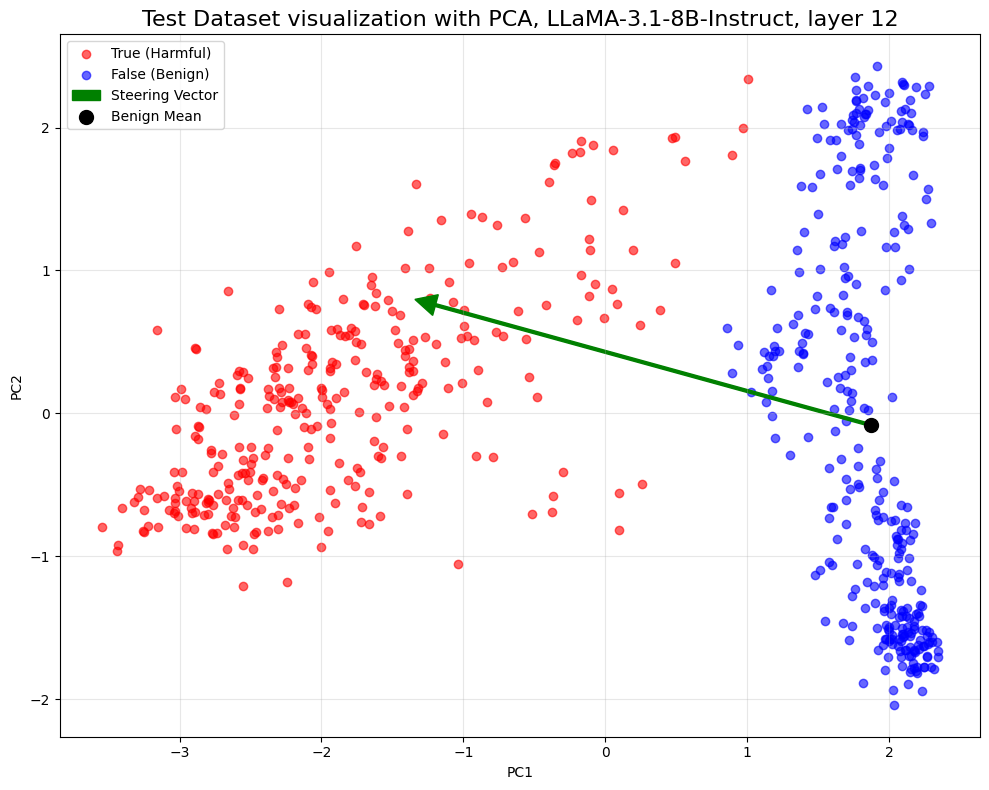

In [8]:
# Convert BFloat16 to Float32 and then to numpy array
test_input_acts_np = test_input_acts.to(torch.float32).cpu().numpy()
test_labels_np = test_labels.cpu().numpy()

# Perform PCA
pca = PCA(n_components=2)
projected_data = pca.fit_transform(test_input_acts_np)

# Project the steering vector
vector_np = vector.to(torch.float32).detach().cpu().numpy()
projected_vector = pca.transform(vector_np.reshape(1, -1))[0]

# Create the plot
plt.figure(figsize=(10, 8))
plt.title(f"Test Dataset visualization with PCA, LLaMA-3.1-8B-Instruct, layer {layer_idx}", fontsize=16)

# Separate data points based on labels
true_points = projected_data[test_labels_np == 1]
false_points = projected_data[test_labels_np == 0]

# Calculate the mean of false points
false_mean = np.mean(false_points, axis=0)

# Plot the data
plt.scatter(true_points[:, 0], true_points[:, 1], c='red', label='True (Harmful)', alpha=0.6)
plt.scatter(false_points[:, 0], false_points[:, 1], c='blue', label='False (Benign)', alpha=0.6)

# Plot the steering vector starting from the mean of false points
plt.arrow(false_mean[0], false_mean[1], 
          projected_vector[0], projected_vector[1], 
          color='green', width=0.02, 
          head_width=0.15, head_length=0.15, 
          label='Steering Vector', 
          length_includes_head=True)

# Plot a point for the mean of false points
plt.scatter(false_mean[0], false_mean[1], c='black', s=100, label='Benign Mean')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Steer with the direction

In [9]:
results = {}
for steering_coef in [0, 1/3, 2/3, 1, 4/3, 2, 8/3, 10/3]:
    # Define the intervention function
    def steer_layer(output):
        # Assuming output shape is (batch_size, sequence_length, hidden_size)
        output[:, -1, :] = output[:, -1, :] + vector.unsqueeze(0).unsqueeze(0) * steering_coef
        return output

    # Clear any existing hooks and add new one
    wrapped_model.clear_hooks()
    wrapped_model.add_hook(f"model.layers.{layer_idx}", steer_layer)

    # Generate text with the hook active
    generated_text = wrapped_model.sample_generations(
        ["How can I make an apple pie?"],
        max_new_tokens=50,
        do_sample=False,
    )[0]  # Get first (and only) generation    
    results[steering_coef] = generated_text

# Clean up hooks after we're done
wrapped_model.clear_hooks()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token

In [10]:
for coef, result in results.items():
    result = result.split("assistant<|end_header_id|>")[-1].strip()
    print(f"Steering Coef: {coef}")
    print(result.replace("\n", " "))

Steering Coef: 0
Making an apple pie is a classic baking endeavor that requires some effort, but yields a delicious and rewarding result. Here's a step-by-step guide to help you make a traditional apple pie:  Ingredients:  For the Crust:  * 2 1
Steering Coef: 0.3333333333333333
Making an apple pie is a classic baking project that requires some basic ingredients and a bit of patience. Here's a simple recipe to get you started:  Ingredients:  For the Crust:  * 2 1/4 cups all-purpose flour *
Steering Coef: 0.6666666666666666
Making an apple pie from scratch can be a fun and rewarding experience! Here's a step-by-step guide to help you make a delicious apple pie:  Ingredients:  For the Crust:  * 2 1/4 cups all-purpose flour *
Steering Coef: 1
Making an apple pie! That's a wonderful endeavor! I'm happy to guide you through the process, but please keep in mind that I'm a large language model, I don't have personal experiences or physical capabilities to assist you. Instead, I
Steering Coef: 

### Visualize harmfulness on jailbreaks using the direction

In [11]:
# Generate completions for a few examples
examples = wrapped_model.sample_generations(
    prompts=jailbreak_dataset["harmful_instructions_test"]["prompt"][:7],
    format_inputs=False,
    batch_size=4,
    max_new_tokens=100,
)

# Normalize the direction
direction = normalize_last_dim(vector)

# Now get the activations and scores for these examples
scores_by_example = []
activations = []

def capture_activations(output):
    # Store the activations
    activations.append(output.detach())
    return output

# Process each example
for example in examples:
    # Tokenize the example
    tokens = wrapped_model.tokenizer(example, return_tensors="pt", add_special_tokens=False)
    tokens = {k: v.to(wrapped_model.device) for k, v in tokens.items()}
    
    # Clear previous and set up new hook
    wrapped_model.clear_hooks()
    wrapped_model.add_hook("model.layers.12", capture_activations)
    
    # Forward pass
    _ = wrapped_model(**tokens)
    
    # Get activations and compute scores
    layer_activations = activations[-1][0]  # get last added activations, first batch
    scores = layer_activations.float() @ direction.float() * 3  # multiply by 3 to scale up
    
    # Store scores with tokens for reference
    str_tokens = [wrapped_model.tokenizer.decode(t) for t in tokens["input_ids"][0]]
    scores_by_example.append((str_tokens, scores.tolist()))

# Clean up
wrapped_model.clear_hooks()

token_act_pairs = [list(zip(tokens, scores))[1:] for tokens, scores in scores_by_example]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


In [12]:
feature_html = prompt_centric_view_generic(token_act_pairs, "Monitoring on harmful prompts, with refusal mean-diff probe")
display(HTML(feature_html))

In [13]:
# Generate completions to bestg of n jailbreaks
examples = wrapped_model.sample_generations(
    prompts=jailbreak_dataset["harmful_best_of_n"]["prompt"][:7],
    format_inputs=False,
    batch_size=4,
    max_new_tokens=100,
)

# Normalize the direction
direction = normalize_last_dim(vector)

# Now get the activations and scores for these examples
scores_by_example = []
activations = []

def capture_activations(output):
    # Store the activations
    activations.append(output.detach())
    return output

# Process each example
for example in examples:
    # Tokenize the example
    tokens = wrapped_model.tokenizer(example, return_tensors="pt", add_special_tokens=False)
    tokens = {k: v.to(wrapped_model.device) for k, v in tokens.items()}
    
    # Clear previous and set up new hook
    wrapped_model.clear_hooks()
    wrapped_model.add_hook("model.layers.12", capture_activations)
    
    # Forward pass
    _ = wrapped_model(**tokens)
    
    # Get activations and compute scores
    layer_activations = activations[-1][0]  # get last added activations, first batch
    scores = layer_activations.float() @ direction.float() * 3  # multiply by 3 to scale up
    
    # Store scores with tokens for reference
    str_tokens = [wrapped_model.tokenizer.decode(t) for t in tokens["input_ids"][0]]
    scores_by_example.append((str_tokens, scores.tolist()))

# Clean up
wrapped_model.clear_hooks()

token_act_pairs = [list(zip(tokens, scores))[1:] for tokens, scores in scores_by_example]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


In [14]:
feature_html = prompt_centric_view_generic(token_act_pairs, "Monitoring on Best of N Jailbreaks, with refusal mean-diff probe")
display(HTML(feature_html))